In [1]:
# import keras
from tensorflow import keras
import models
from utils.image import read_image_bgr, preprocess_image, resize_image
from utils.visualization import draw_box, draw_caption
from utils.colors import label_color

# import miscellaneous modules
import cv2
import os
import os.path as osp
import numpy as np
import time
import glob
import matplotlib.pyplot as plt

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf
from utils.anchors import guess_shapes, compute_locations

# use this environment flag to change which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path = './snapshots/pascal_densenet121/densenet121_pascal.h5'

# load retinanet model
model = models.load_model(model_path, backbone_name='densenet121')

# if the model is not converted to an inference model, use the line below
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
model = models.convert_model(model)
model.load_weights('./snapshots/pascal_densenet121/finetuned/densenet121_pascal.h5')

Instructions for updating:
Use fn_output_signature instead


In [3]:
# load label to names mapping for visualization purposes
voc_classes = {
    'aeroplane': 0,
    'bicycle': 1,
    'bird': 2,
    'boat': 3,
    'bottle': 4,
    'bus': 5,
    'car': 6,
    'cat': 7,
    'chair': 8,
    'cow': 9,
    'diningtable': 10,
    'dog': 11,
    'horse': 12,
    'motorbike': 13,
    'person': 14,
    'pottedplant': 15,
    'sheep': 16,
    'sofa': 17,
    'train': 18,
    'tvmonitor': 19
}
labels_to_names = {}
for key, value in voc_classes.items():
    labels_to_names[value] = key

[array([100, 134]), array([50, 67]), array([25, 34]), array([13, 17]), array([7, 9])]
(13400, 2)
(3350, 2)
(850, 2)
(221, 2)
(63, 2)
processing time:  4.320289850234985


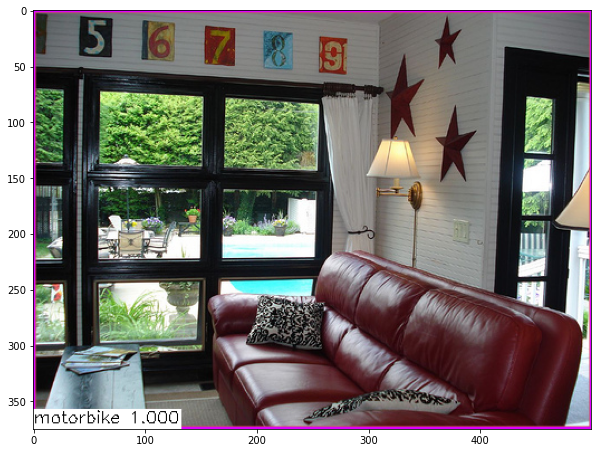

In [4]:
# load image
image_paths = glob.glob('/datasets/dataset/VOCdevkit/VOC2012/JPEGImages/*.jpg')

image_path = np.random.choice(image_paths)
image = read_image_bgr(image_path)

# copy to draw on
draw = np.copy(image)[...,::-1].astype('uint8')

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

feature_shapes = guess_shapes(image.shape)
print(feature_shapes)
locations = compute_locations(feature_shapes)
for location in locations:
    print(location.shape)
# process image
start = time.time()
# locations, feature_shapes = model.predict_on_batch(np.expand_dims(image, axis=0))
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale
labels_to_locations = {}
# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break
    start_x = int(box[0])
    start_y = int(box[1])
    end_x = int(box[2])
    end_y = int(box[3])
    color = label_color(label)

    b = box.astype(int)
    draw_box(draw, b, color=color)

    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)

plt.figure(figsize=(10,10))
plt.imshow(draw)